## NBL TOTAL SHOTS DATA
### Finishing cleaning, graphing, modeling.  Preparing for Tableau.
#### All code in Python 3
#### Authored by Eric Nesi

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV, cross_val_score


plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


The goal here is to finish cleaning this data, put together some graphs, run it through the model I set up when I just had Kings data, and prepare the data for Tableau.  I will be using a lot of the same process as I used in my Part 2/Part 3 EDA, as I the data is very similar.

In [3]:
#read in my csv
nbl_total_data = pd.read_csv('/Users/ericnesi/Desktop/capstone_eric/datasets/allnbl_done.csv', encoding = "utf-8")

In [4]:
nbl_total_data.head()

,GMID,Team,teamScore,opponent,opponentScore,Player,PlayerNo,X,Y,ShotType,SubType,Result,Quarter
0,1,Perth Wildcats,95,Adelaide 36ers,84,J. McKay,5,10.018,50.680,2pt,jumpshot,0,1
1,1,Perth Wildcats,95,Adelaide 36ers,84,C. Prather,23,9.836,56.803,2pt,jumpshot,0,1
2,1,Perth Wildcats,95,Adelaide 36ers,84,J. McKay,5,7.104,54.082,2pt,jumpshot,1,1
3,1,Perth Wildcats,95,Adelaide 36ers,84,D. Martin,53,10.383,36.395,2pt,jumpshot,1,1
4,1,Perth Wildcats,95,Adelaide 36ers,84,J. McKay,5,8.015,56.463,2pt,jumpshot,1,1


In [5]:
#Change Alleyoop to Dunk.  I'm not trying to track alleyoops.  
nbl_total_data.loc[nbl_total_data.SubType == 'alleyoop', 'SubType'] = "dunk"

#Calc 3pt made
nbl_total_data['3PM'] = 0
nbl_total_data.loc[(nbl_total_data.ShotType=='3pt')&(nbl_total_data.Result == 1), '3PM'] = 1

#Change empty SubType for 3pts
nbl_total_data.loc[nbl_total_data.ShotType == '3pt', 'SubType'] = "three"

In [6]:
#check nulls
nbl_total_data.isnull().sum().sort_values(ascending=False).head(5)

3PM         0
Quarter     0
Result      0
SubType     0
ShotType    0
dtype: int64

In [7]:
nbl_total_data['Result'] = nbl_total_data['Result'].astype(int)

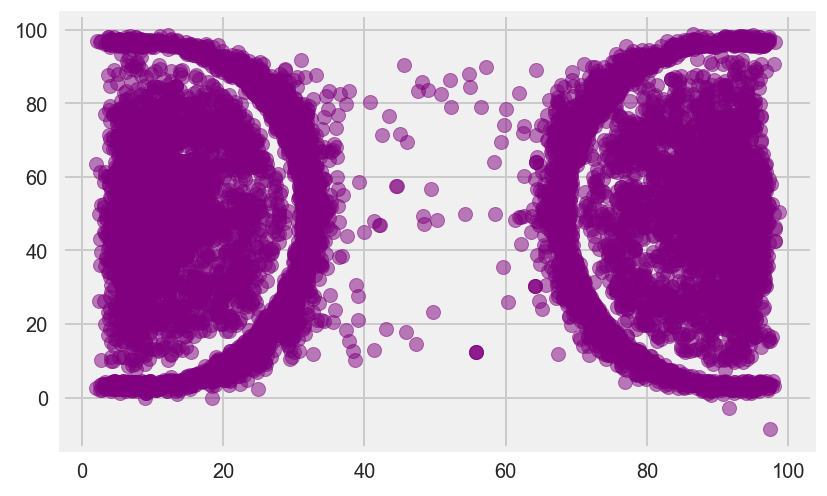

In [8]:
#quick scatterplot
plt.scatter(nbl_total_data.X, nbl_total_data.Y, facecolors = 'purple', alpha = .5)
plt.show()

Scatter plot reveals that I need to flip the data because scraping takes data from both sides of the court.  If I subtract 100 from both X,Y for points that have an X>50, I will be able to not only bring the data to one half court view, but also right-hand side, left-hand side shots will be correct.  

In [9]:
#Change X and Y to be all on one side of the court
#Have to change both X and Y
#Checked with video to make sure
nbl_total_data.loc[(nbl_total_data.X<50), 'Y'] = 100-nbl_total_data.Y
nbl_total_data.loc[(nbl_total_data.X>50), 'X'] = 100-nbl_total_data.X

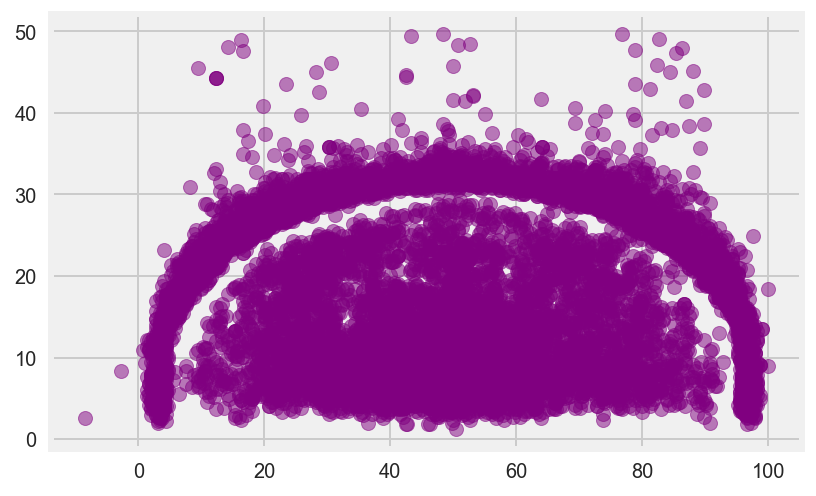

In [10]:
plt.scatter(nbl_total_data.Y, nbl_total_data.X, facecolors = 'purple', alpha = .5)
plt.show()

In [11]:
nbl_total_data.loc[(nbl_total_data['Y'] >100)]

,GMID,Team,teamScore,opponent,opponentScore,Player,PlayerNo,X,Y,ShotType,SubType,Result,Quarter,3PM


In [12]:
#Center Dunks on the hoop
nbl_total_data.loc[nbl_total_data.SubType == 'dunk', 'X'] = 5.5
nbl_total_data.loc[nbl_total_data.SubType == 'tipin', 'X'] = 5.5
nbl_total_data.loc[nbl_total_data.SubType == 'dunk', 'Y'] = 50
nbl_total_data.loc[nbl_total_data.SubType == 'tipin', 'Y'] = 50

#Calculate Distance in Meters
X_hoop = 5.5
Y_hoop = 50

mpy = 15/100
mpx = 14/50


nbl_total_data['distance_m'] = np.sqrt(((X_hoop*mpx) - (mpx*nbl_total_data['X']))**2 + ((mpy*Y_hoop) - (mpy*nbl_total_data['Y']))**2)


#Remove Distances over 12m
nbl_total_data = nbl_total_data.loc[nbl_total_data['distance_m'] < 12]

#Remove Records over 100 degrees Y, less than 0 degrees Y
#These are out of bounds and will be treated as outliers
nbl_total_data = nbl_total_data.loc[(nbl_total_data['Y'] >0)&(nbl_total_data['Y']<100)]


In [13]:
nbl_total_data.head()

,GMID,Team,teamScore,opponent,opponentScore,Player,PlayerNo,X,Y,ShotType,SubType,Result,Quarter,3PM,distance_m
0,1,Perth Wildcats,95,Adelaide 36ers,84,J. McKay,5,10.018,49.320,2pt,jumpshot,0,1,0,1.269145
1,1,Perth Wildcats,95,Adelaide 36ers,84,C. Prather,23,9.836,43.197,2pt,jumpshot,0,1,0,1.585972
2,1,Perth Wildcats,95,Adelaide 36ers,84,J. McKay,5,7.104,45.918,2pt,jumpshot,1,1,0,0.759355
3,1,Perth Wildcats,95,Adelaide 36ers,84,D. Martin,53,10.383,63.605,2pt,jumpshot,1,1,0,2.456421
4,1,Perth Wildcats,95,Adelaide 36ers,84,J. McKay,5,8.015,43.537,2pt,jumpshot,1,1,0,1.198220


In [14]:
#Create my Court Location column
nbl_total_data['X'] = nbl_total_data['X'].astype(float)
nbl_total_data['Y'] = nbl_total_data['Y'].astype(float)
nbl_total_data['Court_Loc'] = 'Backcourt'
nbl_total_data.loc[nbl_total_data.distance_m<1.25, 'Court_Loc'] = 'Restricted_Area'
nbl_total_data.loc[(nbl_total_data.distance_m>1.25)&(nbl_total_data.Y>=33.66)&(nbl_total_data.Y<=66.33)&(nbl_total_data.X<=20.71), 'Court_Loc'] = 'In_the_Paint'
nbl_total_data.loc[(nbl_total_data.distance_m>2.45)&(nbl_total_data.ShotType == '2pt')&(nbl_total_data.Y<33.66)&(nbl_total_data.X<=11), 'Court_Loc'] = 'Right_Corner'
nbl_total_data.loc[(nbl_total_data.distance_m>6.5)&(nbl_total_data.ShotType == '3pt')&(nbl_total_data.Y<20)&(nbl_total_data.X<=11), 'Court_Loc'] = 'Right_Corner_3pt'
nbl_total_data.loc[(nbl_total_data.distance_m>2.5)&(nbl_total_data.ShotType == '2pt')&(nbl_total_data.Y<33.66)&(nbl_total_data.X>11), 'Court_Loc'] = 'Right_Wing'
nbl_total_data.loc[(nbl_total_data.distance_m>6.5)&(nbl_total_data.distance_m<10.2)&(nbl_total_data.ShotType == '3pt')&(nbl_total_data.Y<33.66)&(nbl_total_data.X>11), 'Court_Loc'] = 'Right_Wing_3pt'
nbl_total_data.loc[(nbl_total_data.distance_m<7)&(nbl_total_data.ShotType=='2pt')&(nbl_total_data.Y>=33.66)&(nbl_total_data.Y<=66.33)&(nbl_total_data.X>=20.71), 'Court_Loc'] = 'Top_of_Key'
nbl_total_data.loc[(nbl_total_data.distance_m>6.5)&(nbl_total_data.ShotType=='3pt')&(nbl_total_data.distance_m<10.2)&(nbl_total_data.Y>=33.66)&(nbl_total_data.Y<=66.33)&(nbl_total_data.X>=21), 'Court_Loc'] = 'Top_of_Key_3pt'
nbl_total_data.loc[(nbl_total_data.distance_m>2.45)&(nbl_total_data.ShotType == '2pt')&(nbl_total_data.Y>66.33)&(nbl_total_data.X<=11), 'Court_Loc'] = 'Left_Corner'
nbl_total_data.loc[(nbl_total_data.distance_m>6.5)&(nbl_total_data.ShotType == '3pt')&(nbl_total_data.Y>70)&(nbl_total_data.X<=11), 'Court_Loc'] = 'Left_Corner_3pt'
nbl_total_data.loc[(nbl_total_data.distance_m>2.45)&(nbl_total_data.ShotType == '2pt')&(nbl_total_data.Y>66.33)&(nbl_total_data.X>11), 'Court_Loc'] = 'Left_Wing'
nbl_total_data.loc[(nbl_total_data.distance_m>6.5)&(nbl_total_data.distance_m<10.2)&(nbl_total_data.ShotType == '3pt')&(nbl_total_data.Y>66.33)&(nbl_total_data.X>11), 'Court_Loc'] = 'Left_Wing_3pt'

In [15]:
nbl_total_data.head()

,GMID,Team,teamScore,opponent,opponentScore,Player,PlayerNo,X,Y,ShotType,SubType,Result,Quarter,3PM,distance_m,Court_Loc
0,1,Perth Wildcats,95,Adelaide 36ers,84,J. McKay,5,10.018,49.320,2pt,jumpshot,0,1,0,1.269145,In_the_Paint
1,1,Perth Wildcats,95,Adelaide 36ers,84,C. Prather,23,9.836,43.197,2pt,jumpshot,0,1,0,1.585972,In_the_Paint
2,1,Perth Wildcats,95,Adelaide 36ers,84,J. McKay,5,7.104,45.918,2pt,jumpshot,1,1,0,0.759355,Restricted_Area
3,1,Perth Wildcats,95,Adelaide 36ers,84,D. Martin,53,10.383,63.605,2pt,jumpshot,1,1,0,2.456421,In_the_Paint
4,1,Perth Wildcats,95,Adelaide 36ers,84,J. McKay,5,8.015,43.537,2pt,jumpshot,1,1,0,1.198220,Restricted_Area


In [16]:
nbl_total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15923 entries, 0 to 15945
Data columns (total 16 columns):
GMID             15923 non-null object
Team             15923 non-null object
teamScore        15923 non-null object
opponent         15923 non-null object
opponentScore    15923 non-null object
Player           15923 non-null object
PlayerNo         15923 non-null int64
X                15923 non-null float64
Y                15923 non-null float64
ShotType         15923 non-null object
SubType          15923 non-null object
Result           15923 non-null int64
Quarter          15923 non-null int64
3PM              15923 non-null int64
distance_m       15923 non-null float64
Court_Loc        15923 non-null object
dtypes: float64(3), int64(4), object(9)
memory usage: 2.1+ MB


In [17]:
#reset index
nbl_total_data.index = range(0,len(nbl_total_data))

In [18]:
#Change data of teamscore to just numbers, and set as int
nbl_total_data['teamScore'] = nbl_total_data['teamScore'].str.replace(r'\D+', '')
nbl_total_data['opponentScore'] = nbl_total_data['opponentScore'].str.replace(r'\D+', '')
nbl_total_data[['teamScore','opponentScore']] = nbl_total_data[['teamScore','opponentScore']].apply(pd.to_numeric, errors='coerce')


In [19]:
nbl_total_data.isnull().sum()

GMID             0
Team             0
teamScore        0
opponent         0
opponentScore    0
Player           0
PlayerNo         0
X                0
Y                0
ShotType         0
SubType          0
Result           0
Quarter          0
3PM              0
distance_m       0
Court_Loc        0
dtype: int64

In [20]:
nbl_total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15923 entries, 0 to 15922
Data columns (total 16 columns):
GMID             15923 non-null object
Team             15923 non-null object
teamScore        15923 non-null int64
opponent         15923 non-null object
opponentScore    15923 non-null int64
Player           15923 non-null object
PlayerNo         15923 non-null int64
X                15923 non-null float64
Y                15923 non-null float64
ShotType         15923 non-null object
SubType          15923 non-null object
Result           15923 non-null int64
Quarter          15923 non-null int64
3PM              15923 non-null int64
distance_m       15923 non-null float64
Court_Loc        15923 non-null object
dtypes: float64(3), int64(6), object(7)
memory usage: 1.9+ MB


In [21]:
nbl_total_data.to_csv('/Users/ericnesi/Desktop/capstone_eric/datasets/NBL.csv')

In [74]:
#Set my X_features and append to dataframe
X_features = nbl_total_data[['Court_Loc','Quarter']]
X_features = pd.concat([pd.get_dummies(X_features[col]) for col in X_features], axis=1)
X_features['distance_m'] = nbl_total_data['distance_m']

In [75]:
X_features.head()

,Backcourt,In_the_Paint,Left_Corner,Left_Corner_3pt,Left_Wing,Left_Wing_3pt,Restricted_Area,Right_Corner,Right_Corner_3pt,Right_Wing,Right_Wing_3pt,Top_of_Key,Top_of_Key_3pt,1,2,3,4,distance_m
0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.269145
1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.585972
2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.759355
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.456421
4,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1.198220


#### **Random Forest:**

In [46]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xs = ss.fit_transform(X_features)

Y = nbl_total_data['Result']

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Xtrain, Xtest, ytrain, ytest = train_test_split(Xs, Y, test_size=0.33)

dtc = DecisionTreeClassifier(max_depth=None, max_features='auto')
dtc.fit(Xtrain, ytrain)
print ('dtc acc:', dtc.score(Xtest, ytest))

rf = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto')
rf.fit(Xtrain, ytrain)
yhat = rf.predict(Xtest)
print ('rf acc:', accuracy_score(ytest, yhat))


dtc acc: 0.555280685062
rf acc: 0.563463368221


#### **Logistic Regression:**

In [48]:
# Set parameters for gridsearching
# Taken from 6.3.3. and 6.3.4

gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=5, verbose=1)
print (lr_gridsearch)


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': array([  1.00000e-05,   1.12332e-05, ...,   8.90215e-01,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)


In [49]:
# TTS our data.
# We will have a holdout set to test on at the end.
X_train, X_test, y_train, y_test = train_test_split(Xs, Y, test_size=0.3, random_state=12)

In [50]:
lr_gridsearch.fit(X_train, y_train)

print (lr_gridsearch.best_score_)
print (lr_gridsearch.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.631885878342
{'C': 0.00011497569953977356, 'penalty': 'l2', 'solver': 'liblinear'}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   36.5s finished


In [51]:
bestfit = {'C': 0.00011497569953977356, 'penalty':'l2', 'solver': 'liblinear'}

logreg = LogisticRegression(C=0.00011497569953977356, penalty='l2', solver='liblinear')

logreg.fit(X_train, y_train)

LogisticRegression(C=0.00011497569953977356, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [52]:
Y_pred = logreg.predict(X_test)

# stores confusion matrix for Y Test and Y Pred  
conmat = confusion_matrix(y_test, Y_pred, labels=logreg.classes_)
# converts np.matrix format matrix to a dataframe and adds index and column names
conmat = pd.DataFrame(conmat, columns=logreg.classes_, index=logreg.classes_)

print ('best params for Result:')
print (conmat)

best params for Result:
      0    1
0  2261  438
1  1328  750


In [53]:
print(classification_report(y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.63      0.84      0.72      2699
          1       0.63      0.36      0.46      2078

avg / total       0.63      0.63      0.61      4777



In [54]:
best_lr = lr_gridsearch.best_estimator_

print (best_lr.score(Xs, Y))


0.631727689506


In [55]:
coef_df = pd.DataFrame({
        'coef':best_lr.coef_[0],
        'feature':X_features.columns
    })


coef_df['abs_coef'] = np.abs(coef_df.coef)

# sort by absolute value of coefficient (magnitude)
coef_df.sort_values('abs_coef', ascending=False, inplace=True)

coef_df.head(12)

,coef,feature,abs_coef
6,0.103594,Restricted_Area,0.103594
17,-0.084707,distance_m,0.084707
10,-0.027401,Right_Wing_3pt,0.027401
7,-0.021058,Right_Corner,0.021058
12,-0.020943,Top_of_Key_3pt,0.020943
2,-0.020178,Left_Corner,0.020178
5,-0.019404,Left_Wing_3pt,0.019404
1,-0.014384,In_the_Paint,0.014384
9,-0.013141,Right_Wing,0.013141
0,-0.010782,Backcourt,0.010782


Interesting result here.  Despite the lack of accuracy.  The fact that no other feature other than the shot being in the restricted area has a positive correlation.  When looking at Tableau results, it seemed that the three pointer in the Right Corner, Left Corner, Left Wing, and Right Wing, were all effective.  

In [56]:
print(nbl_total_data.shape)
print(nbl_total_data.Court_Loc.unique())

(15923, 16)
['In_the_Paint' 'Restricted_Area' 'Top_of_Key' 'Right_Wing_3pt'
 'Right_Corner_3pt' 'Left_Wing_3pt' 'Top_of_Key_3pt' 'Right_Wing'
 'Left_Wing' 'Right_Corner' 'Backcourt' 'Left_Corner_3pt' 'Left_Corner']


In [93]:
#Check percentages of court locations. What percentage of shots are in each area?
print(np.sum(nbl_total_data.Court_Loc =="Restricted_Area")/15927)
print(np.sum(nbl_total_data.Court_Loc =='Left_Wing_3pt')/15927)
print(np.sum(nbl_total_data.Court_Loc =='Right_Wing_3pt')/15927)
print(np.sum(nbl_total_data.Court_Loc =='Top_of_Key_3pt')/15927)
print(np.sum(nbl_total_data.Court_Loc =='Left_Corner_3pt')/15927)
print(np.sum(nbl_total_data.Court_Loc =='Right_Corner_3pt')/15927)
print(np.sum(nbl_total_data.Court_Loc =='Top_of_Key')/15927)
print(np.sum(nbl_total_data.Court_Loc =='Left_Wing')/15927)
print(np.sum(nbl_total_data.Court_Loc =='Right_Corner')/15927)
print(np.sum(nbl_total_data.Court_Loc =='Left_Corner')/15927)
print(np.sum(nbl_total_data.Court_Loc =='In_the_Paint')/15927)

0.206504677592
0.112199409807
0.119294280153
0.0624097444591
0.0246122935895
0.025805236391
0.0281911219941
0.0401205500094
0.0314560180825
0.0336535442958
0.279336974948


## END